<a href="https://colab.research.google.com/github/Husseinhhameed/Visualize-7scence-Dataset-Trajectory/blob/main/Visualize_7scence_Dataset_Trajectory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required packages
!pip install transforms3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.8 MB/s eta 0:00:00


In [3]:
!pip install opencv-python  # If OpenCV is not already installed

In [4]:
import os
import numpy as np
import cv2
import pickle
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import transforms3d.quaternions as txq
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

Number of sequences: 4
Number of samples: 4003
Number of processed poses: 4000


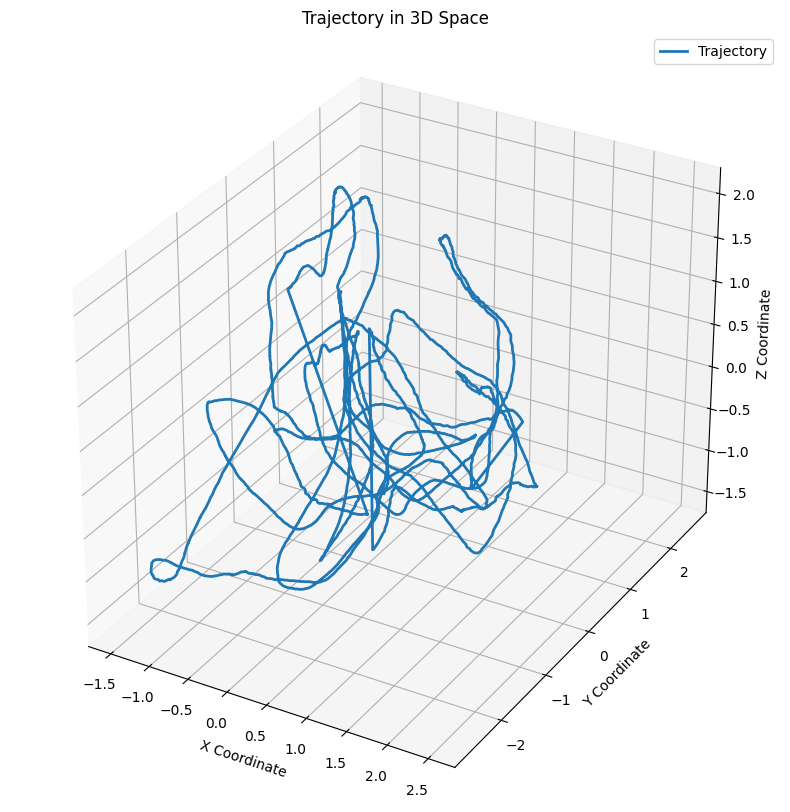

In [8]:
# Functions to process the poses
def process_poses(poses_in, mean_t, std_t, align_R, align_t, align_s):
    poses_out = np.zeros((len(poses_in), 7))
    poses_out[:, 0:3] = poses_in[:, [3, 7, 11]]  # Translation components

    # Align and process rotation
    for i in range(len(poses_out)):
        R = poses_in[i].reshape((3, 4))[:3, :3]
        q = txq.mat2quat(np.dot(align_R, R))
        q *= np.sign(q[0])  # Constrain to hemisphere
        poses_out[i, 3:] = q  # Keep the quaternion as 4D
        t = poses_out[i, :3] - align_t
        poses_out[i, :3] = align_s * np.dot(align_R, t[:, np.newaxis]).squeeze()

    # Normalize translation
    poses_out[:, :3] -= mean_t
    poses_out[:, :3] /= std_t

    return poses_out

def load_and_process_poses(data_dir, seqs, train=True, real=False, vo_lib='orbslam'):
    import glob
    ps = {}
    vo_stats = {}
    all_poses = []
    for seq in seqs:
        seq_dir = os.path.join(data_dir, seq)
        p_filenames = glob.glob(os.path.join(seq_dir, '*.pose.txt'))
        if real:
            pose_file = os.path.join(data_dir, '{:s}_poses'.format(vo_lib), seq)
            pss = np.loadtxt(pose_file)
            frame_idx = pss[:, 0].astype(int)
            if vo_lib == 'libviso2':
                frame_idx -= 1
            ps[seq] = pss[:, 1:13]
            vo_stats_filename = os.path.join(seq_dir, '{:s}_vo_stats.pkl'.format(vo_lib))
            with open(vo_stats_filename, 'rb') as f:
                vo_stats[seq] = pickle.load(f)
        else:
            frame_idx = np.array(range(len(p_filenames)), dtype=int)
            pss = []
            for i in frame_idx:
                pose_path = os.path.join(seq_dir, 'frame-{:06d}.pose.txt'.format(i))
                if os.path.exists(pose_path):
                    pose_data = np.loadtxt(pose_path).flatten()[:12]
                    pss.append(pose_data)
            ps[seq] = np.asarray(pss)
            vo_stats[seq] = {'R': np.eye(3), 't': np.zeros(3), 's': 1}

        all_poses.append(ps[seq])

    all_poses = np.vstack(all_poses)
    pose_stats_filename = os.path.join(data_dir, 'pose_stats.txt')
    if train and not real:
        mean_t = np.mean(all_poses[:, [3, 7, 11]], axis=0)
        std_t = np.std(all_poses[:, [3, 7, 11]], axis=0)
        np.savetxt(pose_stats_filename, np.vstack((mean_t, std_t)), fmt='%8.7f')
    else:
        mean_t, std_t = np.loadtxt(pose_stats_filename)

    # Process and normalize poses
    processed_poses = []
    for seq in seqs:
        pss = process_poses(poses_in=ps[seq], mean_t=mean_t, std_t=std_t,
                            align_R=vo_stats[seq]['R'], align_t=vo_stats[seq]['t'],
                            align_s=vo_stats[seq]['s'])
        processed_poses.append(pss)

    return np.vstack(processed_poses)

# Define the transformation for the images
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Dataset class
class FireDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.seqs = [seq for seq in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, seq))]
        self.samples = self._load_samples()
        self.processed_poses = self._load_processed_poses()

        # Debugging prints
        print(f"Number of sequences: {len(self.seqs)}")
        print(f"Number of samples: {len(self.samples)}")
        print(f"Number of processed poses: {self.processed_poses.shape[0]}")

        # Ensure consistency between samples and processed poses
        min_length = min(len(self.samples), self.processed_poses.shape[0])
        self.samples = self.samples[:min_length]
        self.processed_poses = self.processed_poses[:min_length]

    def _load_samples(self):
        samples = []
        for seq_folder in self.seqs:
            seq_path = os.path.join(self.root_dir, seq_folder)
            color_files = sorted([f for f in os.listdir(seq_path) if f.endswith('.color.png')])
            depth_files = sorted([f for f in os.listdir(seq_path) if f.endswith('.depth.png')])
            pose_files = sorted([f for f in os.listdir(seq_path) if f.endswith('.pose.txt')])

            for color_file, depth_file, pose_file in zip(color_files, depth_files, pose_files):
                samples.append((os.path.join(seq_path, color_file),
                                os.path.join(seq_path, depth_file),
                                os.path.join(seq_path, pose_file)))
        return samples

    def _load_processed_poses(self):
        return load_and_process_poses(self.root_dir, self.seqs)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if idx >= len(self.processed_poses):
            raise IndexError(f"Index {idx} out of bounds for processed poses of size {len(self.processed_poses)}")

        color_path, depth_path, pose_path = self.samples[idx]

        color_image = cv2.imread(color_path, cv2.IMREAD_COLOR)
        depth_image = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
        pose_matrix = self.processed_poses[idx]

        if self.transform:
            color_image = self.transform(color_image)
            depth_image = (depth_image / depth_image.max() * 255).astype(np.uint8)
            depth_image = self.transform(depth_image)

        return color_image, depth_image, pose_matrix

    def plot_trajectory(self):
        # Extract translations
        translations = self.processed_poses[:, :3]
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')

        # Plot the trajectory
        ax.plot(translations[:, 0], translations[:, 1], translations[:, 2], label='Trajectory', linewidth=2)

        # Set labels and title
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')
        ax.set_zlabel('Z Coordinate')
        ax.set_title('Trajectory in 3D Space')

        # Set aspect ratio to 'auto' to prevent distortion
        ax.set_box_aspect([np.ptp(translations[:, 0]),
                           np.ptp(translations[:, 1]),
                           np.ptp(translations[:, 2])])

        # Add legend
        ax.legend()

        plt.show()

# Set the path to your dataset in Google Drive
root_dir = '/content/drive/MyDrive/fire'

# Initialize the dataset
dataset = FireDataset(root_dir=root_dir, transform=transform)

# Plot the trajectory
dataset.plot_trajectory()


In [ ]:
import os
import numpy as np
import cv2
import pickle
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import transforms3d.quaternions as txq
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

Number of sequences: 4
Number of samples: 4003
Number of processed poses: 4000


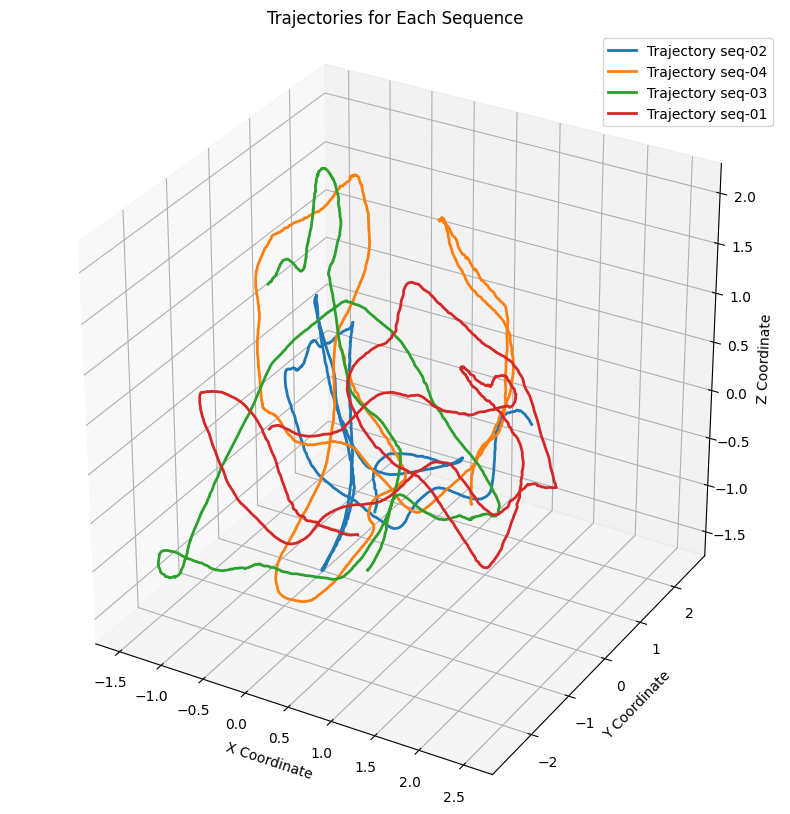

In [9]:
# Functions to process the poses
def process_poses(poses_in, mean_t, std_t, align_R, align_t, align_s):
    poses_out = np.zeros((len(poses_in), 7))
    poses_out[:, 0:3] = poses_in[:, [3, 7, 11]]  # Translation components

    # Align and process rotation
    for i in range(len(poses_out)):
        R = poses_in[i].reshape((3, 4))[:3, :3]
        q = txq.mat2quat(np.dot(align_R, R))
        q *= np.sign(q[0])  # Constrain to hemisphere
        poses_out[i, 3:] = q  # Keep the quaternion as 4D
        t = poses_out[i, :3] - align_t
        poses_out[i, :3] = align_s * np.dot(align_R, t[:, np.newaxis]).squeeze()

    # Normalize translation
    poses_out[:, :3] -= mean_t
    poses_out[:, :3] /= std_t

    return poses_out

def load_and_process_poses(data_dir, seqs, train=True, real=False, vo_lib='orbslam'):
    import glob
    ps = {}
    vo_stats = {}
    all_poses = []
    for seq in seqs:
        seq_dir = os.path.join(data_dir, seq)
        p_filenames = glob.glob(os.path.join(seq_dir, '*.pose.txt'))
        if real:
            pose_file = os.path.join(data_dir, '{:s}_poses'.format(vo_lib), seq)
            pss = np.loadtxt(pose_file)
            frame_idx = pss[:, 0].astype(int)
            if vo_lib == 'libviso2':
                frame_idx -= 1
            ps[seq] = pss[:, 1:13]
            vo_stats_filename = os.path.join(seq_dir, '{:s}_vo_stats.pkl'.format(vo_lib))
            with open(vo_stats_filename, 'rb') as f:
                vo_stats[seq] = pickle.load(f)
        else:
            frame_idx = np.array(range(len(p_filenames)), dtype=int)
            pss = []
            for i in frame_idx:
                pose_path = os.path.join(seq_dir, 'frame-{:06d}.pose.txt'.format(i))
                if os.path.exists(pose_path):
                    pose_data = np.loadtxt(pose_path).flatten()[:12]
                    pss.append(pose_data)
            ps[seq] = np.asarray(pss)
            vo_stats[seq] = {'R': np.eye(3), 't': np.zeros(3), 's': 1}

        all_poses.append(ps[seq])

    all_poses = np.vstack(all_poses)
    pose_stats_filename = os.path.join(data_dir, 'pose_stats.txt')
    if train and not real:
        mean_t = np.mean(all_poses[:, [3, 7, 11]], axis=0)
        std_t = np.std(all_poses[:, [3, 7, 11]], axis=0)
        np.savetxt(pose_stats_filename, np.vstack((mean_t, std_t)), fmt='%8.7f')
    else:
        mean_t, std_t = np.loadtxt(pose_stats_filename)

    # Process and normalize poses
    processed_poses = {}
    for seq in seqs:
        pss = process_poses(poses_in=ps[seq], mean_t=mean_t, std_t=std_t,
                            align_R=vo_stats[seq]['R'], align_t=vo_stats[seq]['t'],
                            align_s=vo_stats[seq]['s'])
        processed_poses[seq] = pss

    return processed_poses

# Define the transformation for the images
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Dataset class
class FireDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.seqs = [seq for seq in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, seq))]
        self.samples = self._load_samples()
        self.processed_poses = self._load_processed_poses()

        # Debugging prints
        print(f"Number of sequences: {len(self.seqs)}")
        print(f"Number of samples: {len(self.samples)}")
        total_poses = sum(len(p) for p in self.processed_poses.values())
        print(f"Number of processed poses: {total_poses}")

    def _load_samples(self):
        samples = []
        self.seq_sample_indices = {}
        idx = 0
        for seq_folder in self.seqs:
            seq_path = os.path.join(self.root_dir, seq_folder)
            color_files = sorted([f for f in os.listdir(seq_path) if f.endswith('.color.png')])
            depth_files = sorted([f for f in os.listdir(seq_path) if f.endswith('.depth.png')])
            pose_files = sorted([f for f in os.listdir(seq_path) if f.endswith('.pose.txt')])

            seq_samples = []
            for color_file, depth_file, pose_file in zip(color_files, depth_files, pose_files):
                seq_samples.append((os.path.join(seq_path, color_file),
                                    os.path.join(seq_path, depth_file),
                                    os.path.join(seq_path, pose_file)))
                idx += 1
            self.seq_sample_indices[seq_folder] = (len(samples), len(samples) + len(seq_samples))
            samples.extend(seq_samples)
        return samples

    def _load_processed_poses(self):
        return load_and_process_poses(self.root_dir, self.seqs)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        color_path, depth_path, pose_path = self.samples[idx]

        color_image = cv2.imread(color_path, cv2.IMREAD_COLOR)
        depth_image = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)

        # Determine which sequence this sample belongs to
        seq_name = [seq for seq in self.seqs if f'/{seq}/' in color_path]
        if seq_name:
            seq = seq_name[0]
            seq_idx = idx - self.seq_sample_indices[seq][0]
            pose_matrix = self.processed_poses[seq][seq_idx]
        else:
            raise ValueError(f"Sequence not found for sample at index {idx}")

        if self.transform:
            color_image = self.transform(color_image)
            depth_image = (depth_image / depth_image.max() * 255).astype(np.uint8)
            depth_image = self.transform(depth_image)

        return color_image, depth_image, pose_matrix

    def plot_trajectories(self):
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')

        colors = list(mcolors.TABLEAU_COLORS.keys())
        for i, seq in enumerate(self.seqs):
            translations = self.processed_poses[seq][:, :3]

            # Plot each sequence with a different color
            ax.plot(translations[:, 0], translations[:, 1], translations[:, 2],
                    label=f'Trajectory {seq}', linewidth=2, color=mcolors.TABLEAU_COLORS[colors[i % len(colors)]])

        # Set labels and title
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')
        ax.set_zlabel('Z Coordinate')
        ax.set_title('Trajectories for Each Sequence')

        # Set aspect ratio
        ax.set_box_aspect([1, 1, 1])

        # Add legend
        ax.legend()

        plt.show()

# Set the path to your dataset in Google Drive
root_dir = '/content/drive/MyDrive/fire'  # Replace with your dataset path

# Initialize the dataset
dataset = FireDataset(root_dir=root_dir, transform=transform)

# Plot the trajectories
dataset.plot_trajectories()

Number of sequences: 4
Number of samples: 4003
Number of processed poses: 4000


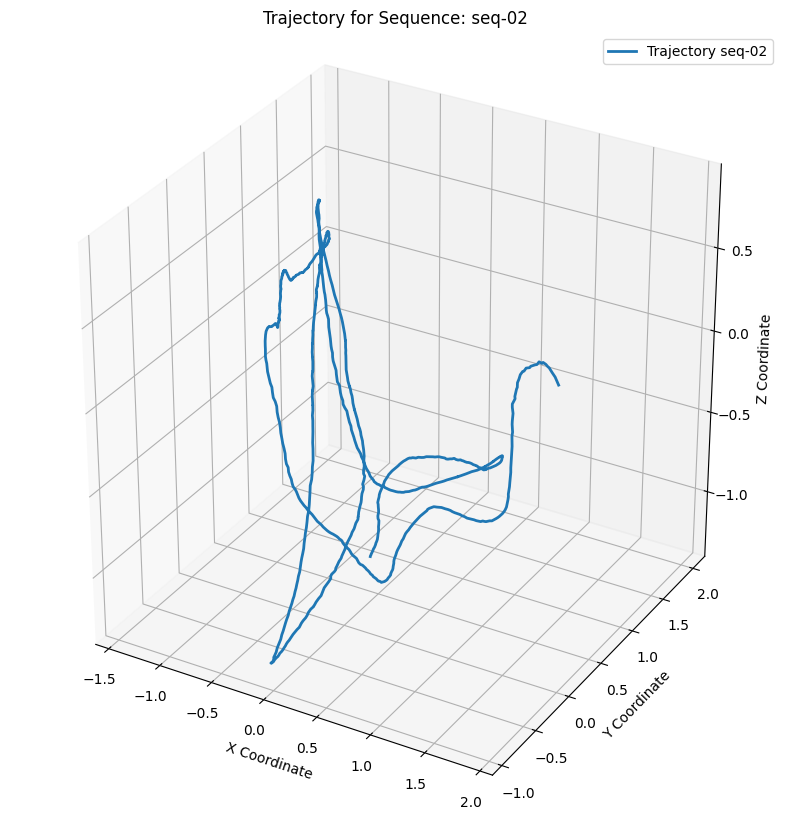

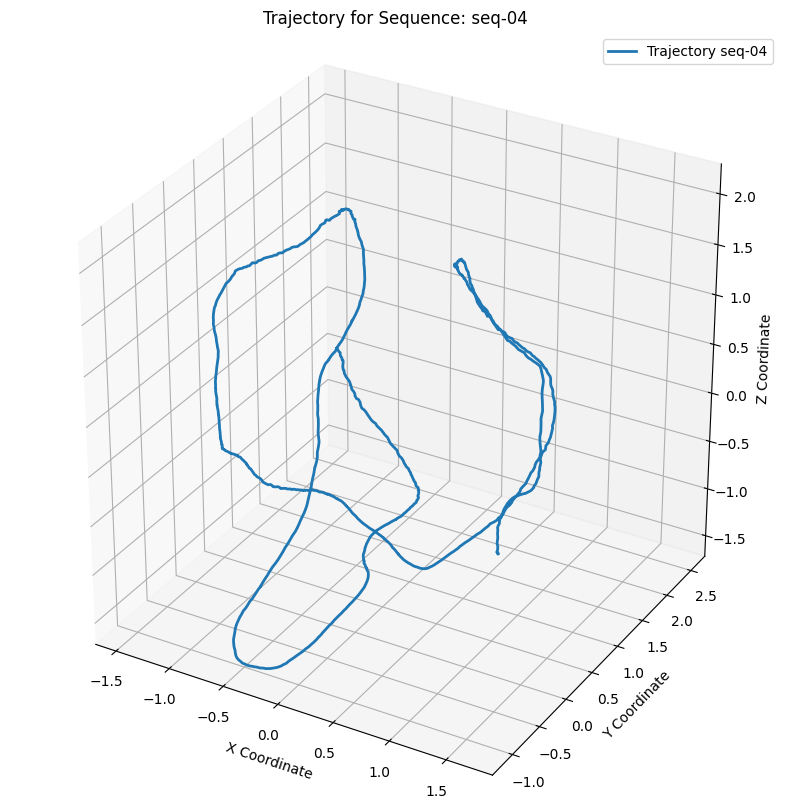

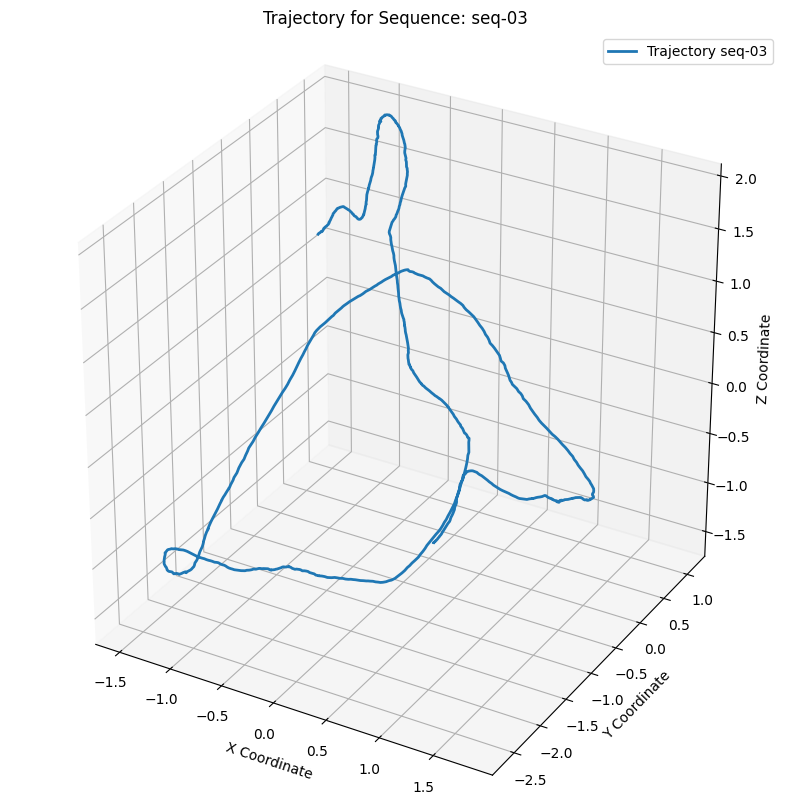

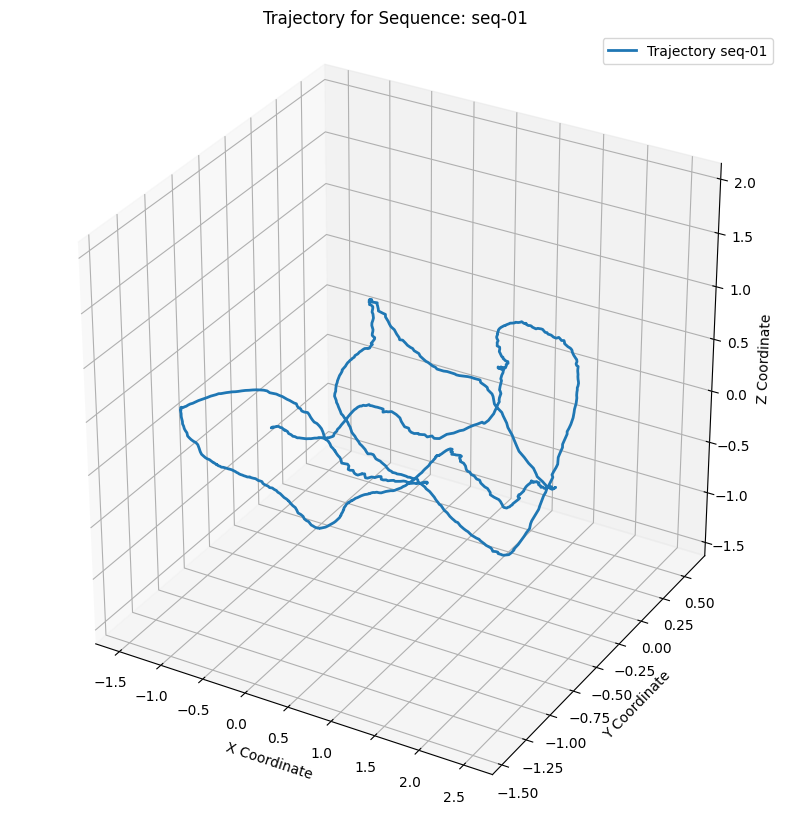

In [10]:
# Functions to process the poses
def process_poses(poses_in, mean_t, std_t, align_R, align_t, align_s):
    poses_out = np.zeros((len(poses_in), 7))
    poses_out[:, 0:3] = poses_in[:, [3, 7, 11]]  # Translation components

    # Align and process rotation
    for i in range(len(poses_out)):
        R = poses_in[i].reshape((3, 4))[:3, :3]
        q = txq.mat2quat(np.dot(align_R, R))
        q *= np.sign(q[0])  # Constrain to hemisphere
        poses_out[i, 3:] = q  # Keep the quaternion as 4D
        t = poses_out[i, :3] - align_t
        poses_out[i, :3] = align_s * np.dot(align_R, t[:, np.newaxis]).squeeze()

    # Normalize translation
    poses_out[:, :3] -= mean_t
    poses_out[:, :3] /= std_t

    return poses_out

def load_and_process_poses(data_dir, seqs, train=True, real=False, vo_lib='orbslam'):
    import glob
    ps = {}
    vo_stats = {}
    all_poses = []
    for seq in seqs:
        seq_dir = os.path.join(data_dir, seq)
        p_filenames = glob.glob(os.path.join(seq_dir, '*.pose.txt'))
        if real:
            pose_file = os.path.join(data_dir, '{:s}_poses'.format(vo_lib), seq)
            pss = np.loadtxt(pose_file)
            frame_idx = pss[:, 0].astype(int)
            if vo_lib == 'libviso2':
                frame_idx -= 1
            ps[seq] = pss[:, 1:13]
            vo_stats_filename = os.path.join(seq_dir, '{:s}_vo_stats.pkl'.format(vo_lib))
            with open(vo_stats_filename, 'rb') as f:
                vo_stats[seq] = pickle.load(f)
        else:
            frame_idx = np.array(range(len(p_filenames)), dtype=int)
            pss = []
            for i in frame_idx:
                pose_path = os.path.join(seq_dir, 'frame-{:06d}.pose.txt'.format(i))
                if os.path.exists(pose_path):
                    pose_data = np.loadtxt(pose_path).flatten()[:12]
                    pss.append(pose_data)
            ps[seq] = np.asarray(pss)
            vo_stats[seq] = {'R': np.eye(3), 't': np.zeros(3), 's': 1}

        all_poses.append(ps[seq])

    all_poses = np.vstack(all_poses)
    pose_stats_filename = os.path.join(data_dir, 'pose_stats.txt')
    if train and not real:
        mean_t = np.mean(all_poses[:, [3, 7, 11]], axis=0)
        std_t = np.std(all_poses[:, [3, 7, 11]], axis=0)
        np.savetxt(pose_stats_filename, np.vstack((mean_t, std_t)), fmt='%8.7f')
    else:
        mean_t, std_t = np.loadtxt(pose_stats_filename)

    # Process and normalize poses
    processed_poses = {}
    for seq in seqs:
        pss = process_poses(poses_in=ps[seq], mean_t=mean_t, std_t=std_t,
                            align_R=vo_stats[seq]['R'], align_t=vo_stats[seq]['t'],
                            align_s=vo_stats[seq]['s'])
        processed_poses[seq] = pss

    return processed_poses

# Define the transformation for the images
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Dataset class
class FireDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.seqs = [seq for seq in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, seq))]
        self.samples = self._load_samples()
        self.processed_poses = self._load_processed_poses()

        # Debugging prints
        print(f"Number of sequences: {len(self.seqs)}")
        print(f"Number of samples: {len(self.samples)}")
        total_poses = sum(len(p) for p in self.processed_poses.values())
        print(f"Number of processed poses: {total_poses}")

    def _load_samples(self):
        samples = []
        self.seq_sample_indices = {}
        idx = 0
        for seq_folder in self.seqs:
            seq_path = os.path.join(self.root_dir, seq_folder)
            color_files = sorted([f for f in os.listdir(seq_path) if f.endswith('.color.png')])
            depth_files = sorted([f for f in os.listdir(seq_path) if f.endswith('.depth.png')])
            pose_files = sorted([f for f in os.listdir(seq_path) if f.endswith('.pose.txt')])

            seq_samples = []
            for color_file, depth_file, pose_file in zip(color_files, depth_files, pose_files):
                seq_samples.append((os.path.join(seq_path, color_file),
                                    os.path.join(seq_path, depth_file),
                                    os.path.join(seq_path, pose_file)))
                idx += 1
            self.seq_sample_indices[seq_folder] = (len(samples), len(samples) + len(seq_samples))
            samples.extend(seq_samples)
        return samples

    def _load_processed_poses(self):
        return load_and_process_poses(self.root_dir, self.seqs)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        color_path, depth_path, pose_path = self.samples[idx]

        color_image = cv2.imread(color_path, cv2.IMREAD_COLOR)
        depth_image = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)

        # Determine which sequence this sample belongs to
        seq_name = [seq for seq in self.seqs if f'/{seq}/' in color_path]
        if seq_name:
            seq = seq_name[0]
            seq_idx = idx - self.seq_sample_indices[seq][0]
            pose_matrix = self.processed_poses[seq][seq_idx]
        else:
            raise ValueError(f"Sequence not found for sample at index {idx}")

        if self.transform:
            color_image = self.transform(color_image)
            depth_image = (depth_image / depth_image.max() * 255).astype(np.uint8)
            depth_image = self.transform(depth_image)

        return color_image, depth_image, pose_matrix

    def plot_trajectories_separately(self):
        for seq in self.seqs:
            translations = self.processed_poses[seq][:, :3]

            fig = plt.figure(figsize=(12, 10))
            ax = fig.add_subplot(111, projection='3d')

            # Plot the trajectory
            ax.plot(translations[:, 0], translations[:, 1], translations[:, 2],
                    label=f'Trajectory {seq}', linewidth=2)

            # Set labels and title
            ax.set_xlabel('X Coordinate')
            ax.set_ylabel('Y Coordinate')
            ax.set_zlabel('Z Coordinate')
            ax.set_title(f'Trajectory for Sequence: {seq}')

            # Set aspect ratio
            ax.set_box_aspect([1, 1, 1])

            # Add legend
            ax.legend()

            plt.show()

# Set the path to your dataset in Google Drive
root_dir = '/content/drive/MyDrive/fire'  # Replace with your dataset path

# Initialize the dataset
dataset = FireDataset(root_dir=root_dir, transform=transform)

# Plot each sequence's trajectory separately
dataset.plot_trajectories_separately()